## Corners Average Reward Comparison
This notebook reads TensorBoard scalars for multiple agent variants in the Corners environment, normalizes their average rewards to the hardcoded oracle, and visualizes the comparison.

In [1]:
import os

import numpy as np
from matplotlib import pyplot as plt
from tbparse import SummaryReader
from tueplots import bundles

# Keep plotting style consistent with existing slides
plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({'font.sans-serif': 'DejaVu Sans', 'figure.dpi': 200})

### Load TensorBoard Scalars
Define shared paths and a helper to pull the average reward scalars for each agent variant.

In [4]:
base_dir = os.path.join("..", "corners")
condition_dirs = {
    "oracle": os.path.join(base_dir, "hardcoded"),
    "ours": os.path.join(base_dir, "ours"),
    "tabular": os.path.join(base_dir, "tabular"),
    "random": os.path.join(base_dir, "random"),
}
condition_names = list(condition_dirs.keys())

def load_avg_reward_df(path: str):
    """Return the Average Episode Reward scalars for a given experiment directory."""
    reader = SummaryReader(path, extra_columns={'dir_name'})
    df = reader.scalars
    return df[df['tag'] == "Average Episode Reward"].reset_index(drop=True)

In [5]:
condition_dfs = {name: load_avg_reward_df(path) for name, path in condition_dirs.items()}
condition_stats = {
    name: {
        "mean": df['value'].mean(),
        "std": df['value'].std(),
        "count": len(df),
    }
    for name, df in condition_dfs.items()
}
condition_stats

{'oracle': {'mean': np.float64(0.5287324027581648),
  'std': np.float64(0.0748744630398282),
  'count': 11},
 'ours': {'mean': np.float64(0.3949050962924957),
  'std': np.float64(0.11322140703707734),
  'count': 10},
 'tabular': {'mean': np.float64(0.050293327495455745),
  'std': np.float64(0.04854661015917922),
  'count': 10},
 'random': {'mean': np.float64(0.06688254810869694),
  'std': np.float64(0.04950109022239744),
  'count': 10}}

### Normalize To Oracle And Plot
Compute normalized summary stats and visualize distributions per agent.

In [51]:
oracle_mean = condition_stats["oracle"]["mean"]
normalized_stats = {
    name: {
        "mean": stats["mean"] / oracle_mean if oracle_mean else np.nan,
        "std": stats["std"] / oracle_mean if oracle_mean else np.nan,
        "count": stats["count"],
    }
    for name, stats in condition_stats.items()
}
normalized_stats

{'oracle': {'mean': np.float64(1.0),
  'std': np.float64(0.1416112624254557),
  'count': 11},
 'ours': {'mean': np.float64(0.7468902874733025),
  'std': np.float64(0.214137447310683),
  'count': 10},
 'tabular': {'mean': np.float64(0.09512056993877722),
  'std': np.float64(0.09181697566847213),
  'count': 10},
 'random': {'mean': np.float64(0.12649602664750648),
  'std': np.float64(0.09362219898794169),
  'count': 10}}

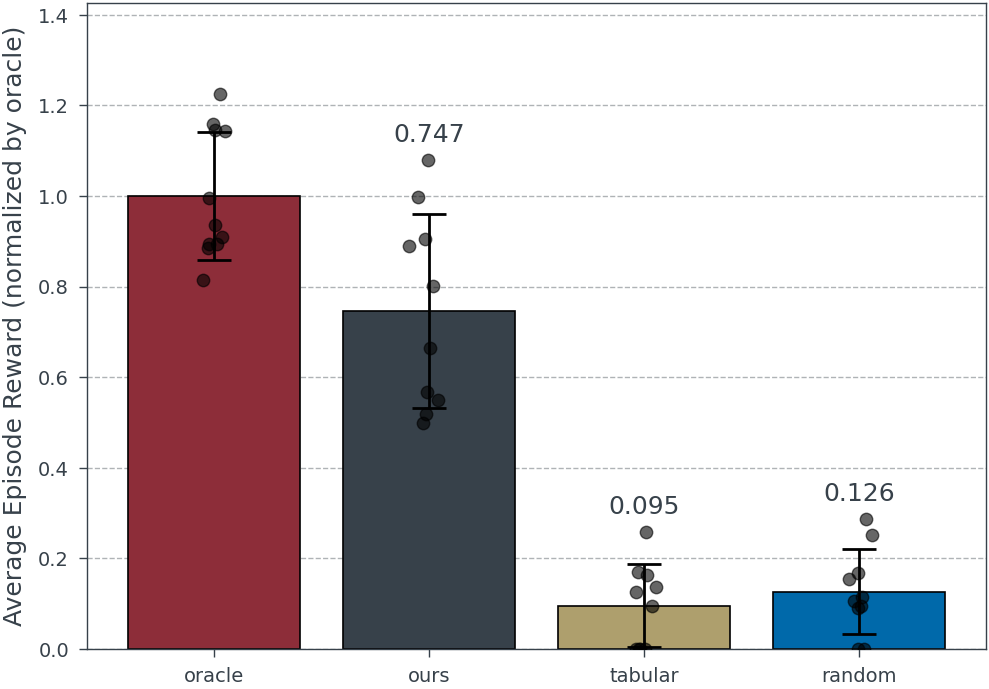

In [52]:
labels = condition_names
means = np.array([normalized_stats[label]["mean"] for label in labels])
stds = np.array([normalized_stats[label]["std"] for label in labels])

prop_cycle = plt.rcParams.get('axes.prop_cycle')
colors = prop_cycle.by_key().get('color', [])[:len(labels)]

fig, ax = plt.subplots(figsize=(5, 3.5))

x = np.arange(len(labels))
ax.bar(x, means, yerr=stds, capsize=6, color=colors, edgecolor='black', linewidth=0.6)

rng = np.random.default_rng(0)  # Stable jitter for scatter plot
normalized_samples = {}
for idx, label in enumerate(labels):
    df_i = condition_dfs[label]
    jitter = rng.normal(0, 0.04, size=len(df_i))
    samples = df_i['value'] / oracle_mean
    ax.scatter(np.full(len(df_i), x[idx]) + jitter, samples,
               color='black', alpha=0.6, s=20, zorder=5)
    normalized_samples[label] = samples.max() if len(samples) else 0.0

for idx, label in enumerate(labels):
    if label == "oracle":
        continue
    y_pos = normalized_samples[label] + 0.03
    ax.text(x[idx], y_pos, f"{means[idx]:.3f}", ha='center', va='bottom', fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Average Episode Reward (normalized by oracle)")
y_upper = max(np.max(means + stds) * 1.25, 1.2, max(normalized_samples.values(), default=1.0) + 0.1)
ax.set_ylim(0, y_upper)
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.show()

### Save Plot
Persist the latest bar plot to disk for use in slides or papers.

In [53]:
plot_path = os.path.join(base_dir, "corners_avg_reward_comparison.pdf")
os.makedirs(os.path.dirname(plot_path), exist_ok=True)
fig.savefig(plot_path, format="pdf", bbox_inches='tight')
plot_path

'outputs\\corners\\corners_avg_reward_comparison.pdf'